## Model 구현

### import

In [1]:
import os
import collections
import math
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import f1_score

from Dataset import ImageDataset

### Special Mission 구현

In [2]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channel, shrink_channel):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channel, shrink_channel, (1, 1), padding=1, bias=False)
        self.conv2 = nn.Conv2d(shrink_channel, in_channel, (3, 3), bias=False)
        self.relu = nn.ReLU()
              
    def forward(self, x):
        x_ = self.conv1(x)
        x_ = self.relu(x_)
        x_ = self.conv2(x_)
        
        x = x + x_
        x = self.relu(x)
        return x
        

class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, (3, 3), padding=1)
        self.layer1 = nn.Sequential(nn.Conv2d(32, 64, (3, 3), stride=2, padding=1, bias=False),
                                     nn.ReLU(),
                                     ResidualBlock(64, 32)
                                    )
        self.layer2 = nn.Sequential(nn.Conv2d(64, 128, (3, 3), stride=2, padding=1, bias=False),
                                     nn.ReLU(),
                                     ResidualBlock(128, 64),
                                     ResidualBlock(128, 64)
                                    )
        self.layer3 = nn.Sequential(nn.Conv2d(128, 256, (3, 3), stride=2, padding=1, bias=False),
                                     nn.ReLU(),
                                     ResidualBlock(256, 128),
                                     ResidualBlock(256, 128),
                                     ResidualBlock(256, 128),
                                     ResidualBlock(256, 128),
                                     ResidualBlock(256, 128),
                                     ResidualBlock(256, 128),
                                     ResidualBlock(256, 128),
                                     ResidualBlock(256, 128)
                                    )
        self.layer4 = nn.Sequential(nn.Conv2d(256, 512, (3, 3), stride=2, padding=1, bias=False),
                                     nn.ReLU(),
                                     ResidualBlock(512, 256),
                                     ResidualBlock(512, 256),
                                     ResidualBlock(512, 256),
                                     ResidualBlock(512, 256),
                                     ResidualBlock(512, 256),
                                     ResidualBlock(512, 256),
                                     ResidualBlock(512, 256),
                                     ResidualBlock(512, 256)
                                    )
        self.layer5 = nn.Sequential(nn.Conv2d(512, 1024, (3, 3), stride=2, padding=1, bias=False),
                                     nn.ReLU(),
                                     ResidualBlock(1024, 512),
                                     ResidualBlock(1024, 512),
                                     ResidualBlock(1024, 512),
                                     ResidualBlock(1024, 512)
                                    )
        
        self.relu = nn.ReLU()
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(1024, 18)
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.avgpool(out)
        out = out.view(out.shape[0], -1)
        out = self.fc(out)
        return out


### Trainer 정의

In [ ]:
class Trainer:
    def __init__(self, model, loss_fn, optimizer, dataset, val_ratio, val_transform=None):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.dataset = dataset
        self.data_cnt = len(self.dataset)
        self.val_ratio = val_ratio
        self.val_transform = val_transform
        self.device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
        self.model = self.model.to(self.device)  
    
    def split_dataset(self, val_ratio):
        data_cnt = len(self.dataset)
        val_cnt = int(data_cnt * val_ratio)
        train_cnt = data_cnt - val_cnt
        train_set, val_set = random_split(self.dataset, [train_cnt, val_cnt])
        if self.val_transform:
            val_set.transform = self.val_transform
        return train_set, val_set
    
    def generate_dataloaders(self, batch_size, shuffle=True, drop_last=False):
        train_dataset, val_dataset = self.split_dataset(0.2)
        train_dataloader = DataLoader(train_dataset, 
                                      batch_size=batch_size, 
                                      shuffle=shuffle,
                                      drop_last=drop_last
                                     )
        val_dataloader = DataLoader(val_dataset, 
                                      batch_size=batch_size, 
                                      shuffle=shuffle,
                                      drop_last=drop_last
                                     )
        return {'train' : train_dataloader,
                'test' : val_dataloader }
    
    def step(self, epoch_size, batch_size):
        dataloaders = self.generate_dataloaders(batch_size)
        
        train_acc_list = []
        train_loss_list = []
        test_acc_list = []
        test_loss_list = []
        
        for epoch in range(epoch_size):
            print(f'{epoch} epoch start({epoch+1}/{epoch_size})')
            
            loss, acc = self.run(batch_size, dataloaders['train'], 'train')
            train_loss_list.append(loss)
            train_acc_list.append(acc)
            
            loss, acc = self.run(batch_size, dataloaders['test'], 'test')
            test_loss_list.append(loss)
            test_acc_list.append(acc)
            
            print(f'{epoch} epoch done({epoch+1}/{epoch_size})')
        
        return [train_loss_list, test_loss_list], [train_acc_list, test_acc_list]
    
    def run(self, batch_size, dataloader, mode='train'):
        loss, acc = 0, 0
        
        if mode == 'train': self.model.train()
        elif mode == 'test': self.model.eval()
        
        for data in (tbar := tqdm(dataloader)):
            X, y = data
            X = X.to(self.device)
            y = y.to(self.device)

            self.optimizer.zero_grad()

            with torch.set_grad_enabled(mode == 'train'):
                label = self.model(X)
                _, predict = torch.max(label, 1)
                loss = self.loss_fn(label, y)

                if mode == 'train':
                    loss.backward()
                    self.optimizer.step()
                            
            loss_mean = loss.item()
            loss += loss_mean
            correct_num = torch.sum(predict == y.data).item()
            acc += correct_num / X.shape[0]
            tbar.set_postfix({'loss': loss_mean, 'acc': correct_num})
        
        loss = loss / len(dataloader)
        acc = acc / len(dataloader)

        return loss, acc

### ResNet18 pretrained model 활용
fc layer의 out_feature를 18로 수정했다.

In [5]:
resnet18_pretrained = torchvision.models.resnet18(pretrained=True)

resnet18_pretrained.fc = nn.Linear(512, 18, bias=True)

torch.nn.init.xavier_uniform_(resnet18_pretrained.fc.weight)
stdv = 1./math.sqrt(resnet18_pretrained.fc.weight.size(1))
resnet18_pretrained.fc.bias.data.uniform_(-stdv, stdv)

# freeze
for name, param in resnet18_pretrained.named_parameters():
    if name in ['fc.weight', 'fc.bias']:
        param.requires_grad = True
    else:
        param.requires_grad = False

### Densenet161 pretrained model 활용
classifier의 out_feature를 18로 수정했다.

In [6]:
densenet_pretrained = torchvision.models.densenet161(pretrained=True)

densenet_pretrained.classifier = nn.Linear(2208, 18, bias=True)

torch.nn.init.xavier_uniform_(densenet_pretrained.classifier.weight)
stdv = 1./math.sqrt(densenet_pretrained.classifier.weight.size(1))
densenet_pretrained.classifier.bias.data.uniform_(-stdv, stdv)

# freeze
for name, param in densenet_pretrained.named_parameters():
    if name in ['classifier.weight', 'classifier.bias']:
        param.require_grad = True
    else:
        param.require_grad = False

### VGG16 pretrained model 활용
classifier 2번째 linear layer의 out_feature를 2048, 3번째 linear layer의 in features, out_feature를 각각 2048, 18로 수정했다.

In [25]:
vggnet_pretrained = torchvision.models.vgg16(pretrained=True)

vggnet_pretrained.classifier[3] = nn.Linear(4096, 2048, bias=True)
vggnet_pretrained.classifier[6] = nn.Linear(2048, 18, bias=True)

for i in [3, 6]:
    torch.nn.init.xavier_uniform_(vggnet_pretrained.classifier[i].weight)
    stdv = 1./math.sqrt(vggnet_pretrained.classifier[i].weight.size(1))
    vggnet_pretrained.classifier[i].bias.data.uniform_(-stdv, stdv)

# freeze
for name, param in densenet_pretrained.named_parameters():
    if name.startswith('classifier'):
        param.require_grad = True
    else:
        param.require_grad = False

### 모델 학습해보기

In [7]:
data_dir = '../input/data/train'

val_transform = transforms.Compose([transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
                                                transforms.ToTensor(),
                                                transforms.CenterCrop((384, 256)),
                                                transforms.Normalize(0.5, 0.2)])

image_dataset = ImageDataset(data_dir, 'new_train.csv', 
                             transform=transforms.Compose([transforms.RandomRotation(degrees = 15),
                                                           transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
                                                           transforms.RandomVerticalFlip(p=0.5),
                                                           transforms.ToTensor(),
                                                           transforms.CenterCrop((384, 256)),
                                                           transforms.Normalize(0.5, 0.2)])
                            )

#### ResNet

In [13]:
loss_fn = nn.CrossEntropyLoss()

learning_rate = 1e-4
optimizer = optim.Adam(resnet18_pretrained.parameters(), lr=learning_rate)

# hyper-parameters
num_epoch = 5
num_batch = 32

resnet_trainer = Trainer(resnet18_pretrained, loss_fn, 
                         optimizer, image_dataset, 0.2, val_transform)

In [15]:
stat = resnet_trainer.step(num_epoch, num_batch)

  0%|          | 0/473 [00:00<?, ?it/s]

0 epoch start(1/5)


  0%|          | 0/473 [00:00<?, ?it/s]

0 epoch done(1/5)
1 epoch start(2/5)


  0%|          | 0/473 [00:00<?, ?it/s]

1 epoch done(2/5)
2 epoch start(3/5)


  0%|          | 0/473 [00:00<?, ?it/s]

2 epoch done(3/5)
3 epoch start(4/5)


  0%|          | 0/473 [00:00<?, ?it/s]

3 epoch done(4/5)
4 epoch start(5/5)


100%|██████████| 119/119 [01:34<00:00,  1.26it/s, loss=2.95, acc=66.6]

4 epoch done(5/5)


#### DenseNet

In [12]:
loss_fn = nn.CrossEntropyLoss()

learning_rate = 1e-4
optimizer = optim.Adam(densenet_pretrained.parameters(), lr=learning_rate)

# hyper-parameters
num_epoch = 5
num_batch = 32

model_trainer = Trainer(densenet_pretrained, loss_fn, optimizer, image_dataset, 0.2)

In [ ]:
stat = model_trainer.step(num_epoch, num_batch)

#### VGG16

In [31]:
loss_fn = nn.CrossEntropyLoss()

learning_rate = 1e-4
optimizer = optim.Adam(vggnet_pretrained.parameters(), lr=learning_rate)

# hyper-parameters
num_epoch = 5
num_batch = 16

model_trainer = Trainer(vggnet_pretrained, loss_fn, optimizer, image_dataset, 0.2)

In [32]:
stat = model_trainer.step(num_epoch, num_batch)

  0%|          | 0/945 [00:00<?, ?it/s]

0 epoch start(1/5)


  0%|          | 0/945 [00:00<?, ?it/s]

0 epoch done(1/5)
1 epoch start(2/5)


  0%|          | 0/945 [00:00<?, ?it/s]

1 epoch done(2/5)
2 epoch start(3/5)


  0%|          | 0/945 [00:00<?, ?it/s]

2 epoch done(3/5)
3 epoch start(4/5)


  0%|          | 0/945 [00:00<?, ?it/s]

3 epoch done(4/5)
4 epoch start(5/5)


100%|██████████| 237/237 [01:44<00:00,  2.27it/s, loss=0.261, acc=206]  

4 epoch done(5/5)


In [33]:
torch.save(vggnet_pretrained, './vgg.pt')

### eval Dataset 정의

In [34]:
class EvalDataset(Dataset):
    '''
    csv 데이터를 통해 만들어진 Dataset Class
    input: base(string)
           filename(string)
           transform(torchvision.transforms.transforms, default=None)
    '''
    
    def __init__(self, base, filename, transform) -> None:
        self.path = base
        self.data = pd.read_csv(self.path+'/'+filename)
        self.transform = transform
    
    def __len__(self) -> int:
        return len(self.data)
    
    def __getitem__(self, idx: int):
        X = np.array(Image.open(self.path+'/images/'+self.data['ImageID'][idx]))
        
        if self.transform:
            X = self.transform(X)
            
        return X


### eval data를 이용해 예측해보기

#### eval/info.csv 읽어오기

In [35]:
eval_dir = '../input/data/eval'
filename = 'info.csv'

test_info = pd.read_csv(eval_dir+'/info.csv')
test_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12600 entries, 0 to 12599
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ImageID  12600 non-null  object
 1   ans      12600 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 197.0+ KB


#### dataset, dataloader 생성 및 eval 함수 정의

In [36]:
batch_size = 128

eval_dir = '../input/data/eval'
filename = 'info.csv'
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

eval_dataset = EvalDataset(eval_dir, filename, transform=transforms.Compose([
                                                                transforms.ToTensor(),
                                                                transforms.CenterCrop((384, 256)),
                                                                transforms.Normalize(0.5, 0.2)])
                                                            )
eval_dataloader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

def eval_model(model, dataloader, device, batch_size, dataframe):
    model.eval()
    for idx, data in enumerate(tbar := tqdm(dataloader)):
        X = data
        X = X.to(device)

        with torch.no_grad():
            label = model(X)
            _, predict = torch.max(label, 1)
        dataframe['ans'].iloc[idx*batch_size:idx*batch_size+predict.shape[0]] = predict.tolist()
        

vgg16 모델을 이용해 예측해보겠다.

In [38]:
eval_model(vggnet_pretrained, eval_dataloader, device, batch_size, test_info)

100%|██████████| 99/99 [01:38<00:00,  1.00it/s]


In [39]:
test_info.to_csv('vgg16base(5, 16, Adam, 1e-4)', sep=',')

#### 결과 시각화
임의의 N개의 결과에 대해 시각화해보겠다.

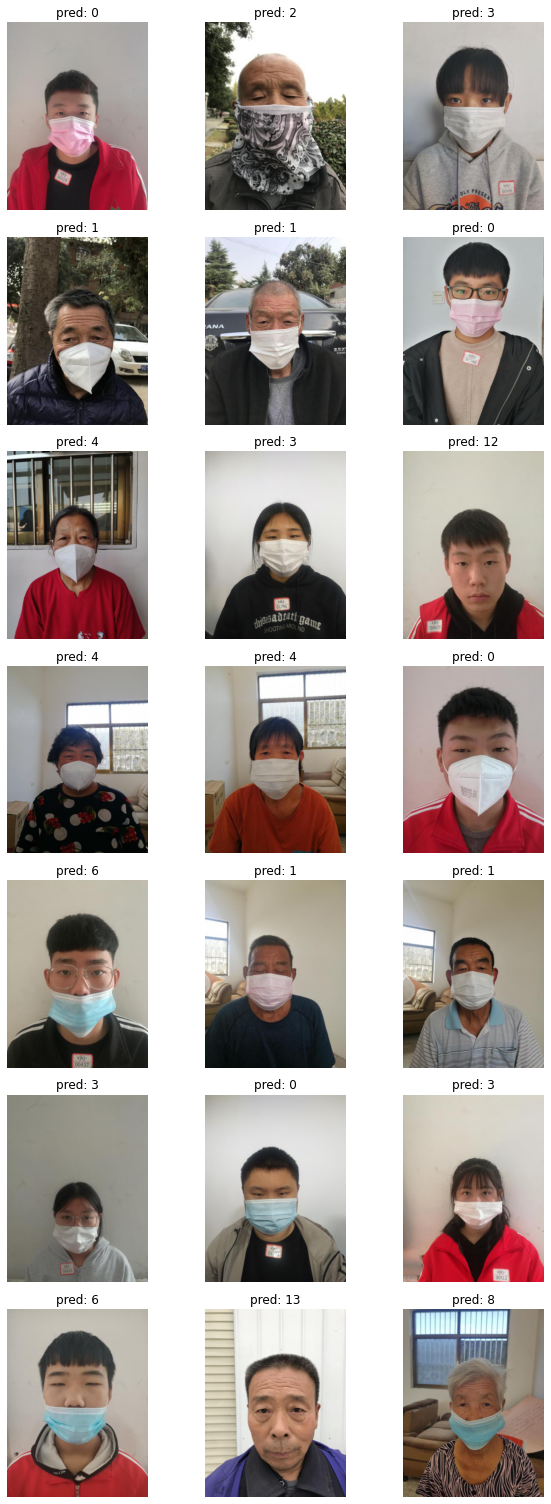

In [40]:
N = 21

fig, ax = plt.subplots(N//3, 3, figsize=(3*3, N))
idxs = np.random.choice(len(test_info), N)
ax = ax.flatten()
for idx, data_idx in enumerate(idxs):
    pred = test_info['ans'].iloc[data_idx]
    image_path = f"{eval_dir}/images/{test_info['ImageID'].iloc[data_idx]}"
    image = plt.imread(image_path)

    ax[idx].set_title(f'pred: {pred}')
    ax[idx].imshow(image)
    ax[idx].axis('off')

plt.tight_layout()